# L2: Build Customized RAG

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
import os
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [2]:
from haystack import Pipeline
from haystack.utils.auth import Secret
from haystack.components.builders import PromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder, CohereTextEmbedder

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

- Fetch Contents from URLs with [`LinkContentFetcher`](https://docs.haystack.deepset.ai/docs/linkcontentfetcher?utm_campaign=developer-relations&utm_source=dlai)
- Convert them to Documents with [`HTMLToDocument`](https://docs.haystack.deepset.ai/docs/htmltodocument?utm_campaign=developer-relations&utm_source=dlai)
- Create embeddings for them with [`CohereDocumentEmbedder`](https://docs.haystack.deepset.ai/docs/coheredocumentembedder?utm_campaign=developer-relations&utm_source=dlai)
- Write them to an [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore?utm_campaign=developer-relations&utm_source=dlai)

> ℹ️ Model providers may have outages. If you encounter issues creating embeddings or generating responses, feel free to consider any of the other [Embedder](https://docs.haystack.deepset.ai/docs/embedders?utm_campaign=developer-relations&utm_source=dlai) or [Generator](https://docs.haystack.deepset.ai/docs/generators?utm_campaign=developer-relations&utm_source=dlai) options. For this lesson, we recomment Cohere embedders, or small [Sentence Transformers](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentembedder?utm_campaign=developer-relations&utm_source=dlai) embedders.

## Indexing Documents


In [3]:
document_store = InMemoryDocumentStore()

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
embedder = CohereDocumentEmbedder(model="embed-english-v3.0", api_base_url=os.getenv("CO_API_URL"))
writer = DocumentWriter(document_store=document_store)

indexing = Pipeline()
indexing.add_component("fetcher", fetcher)
indexing.add_component("converter", converter)
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

indexing.connect("fetcher.streams", "converter.sources")
indexing.connect("converter", "embedder")
indexing.connect("embedder", "writer")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - embedder: CohereDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

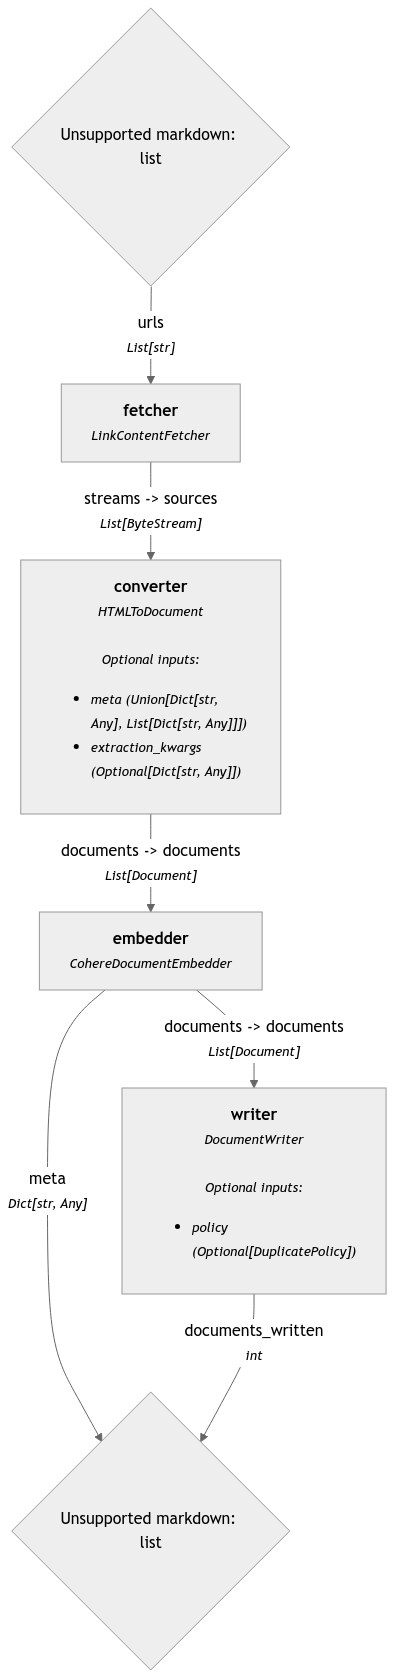

In [4]:
indexing.show()

In [5]:
indexing.run(
    {
        "fetcher": {
            "urls": [
                "https://haystack.deepset.ai/integrations/cohere",
                "https://haystack.deepset.ai/integrations/anthropic",
                "https://haystack.deepset.ai/integrations/jina",
                "https://haystack.deepset.ai/integrations/nvidia",
            ]
        }
    }
)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


{'embedder': {'meta': ApiMeta(api_version=ApiMetaApiVersion(version='unspecified', is_deprecated=True, is_experimental=None), billed_units=ApiMetaBilledUnits(input_tokens=2032.0, output_tokens=None, search_units=None, classifications=None), tokens=None, warnings=['Please set an API version, for more information please refer to https://docs.cohere.com/versioning-reference', 'Version is deprecated, for more information please refer to https://docs.cohere.com/versioning-reference'])},
 'writer': {'documents_written': 4}}

In [6]:
document_store.filter_documents()[0]

Document(id=2e5d1c329299f62ea635c98b0c1640e82468253d4ab0e577a37285ed0d85f68c, content: 'Integration: Cohere
Use Cohere models with Haystack
Table of Contents
- Haystack 2.0
- Haystack 1.x
...', meta: {'content_type': 'text/html', 'url': 'https://haystack.deepset.ai/integrations/cohere'}, embedding: vector of size 1024)

## Retrieval Augmented Generation
### 1. Decide on the Prompt
Augment the prompt with the contents of these documents using the [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder?utm_campaign=developer-relations&utm_source=dlai). This component uses Jinja templating [[+]](https://jinja.palletsprojects.com/en/3.1.x/)

In [7]:
prompt = """
Answer the question based on the provided context.
Context:
{% for doc in documents %}
   {{ doc.content }} 
{% endfor %}
Question: {{ query }}
"""

### 2. Build the Pipeline

In [8]:
query_embedder = CohereTextEmbedder(model="embed-english-v3.0", api_base_url=os.getenv("CO_API_URL"))
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
generator = OpenAIGenerator()

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

🚅 Components
  - query_embedder: CohereTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

> Note: It is possible to use a different model for the generator. For example, if you'd like to use Llama-3, update the code above to:

```
generator = OpenAIGenerator(api_key=Secret.from_env_var("TOGETHER_AI_API"),
                            model="meta-llama/Llama-3-70b-chat-hf",
                            api_base_url="https://api.together.xyz/v1")
```

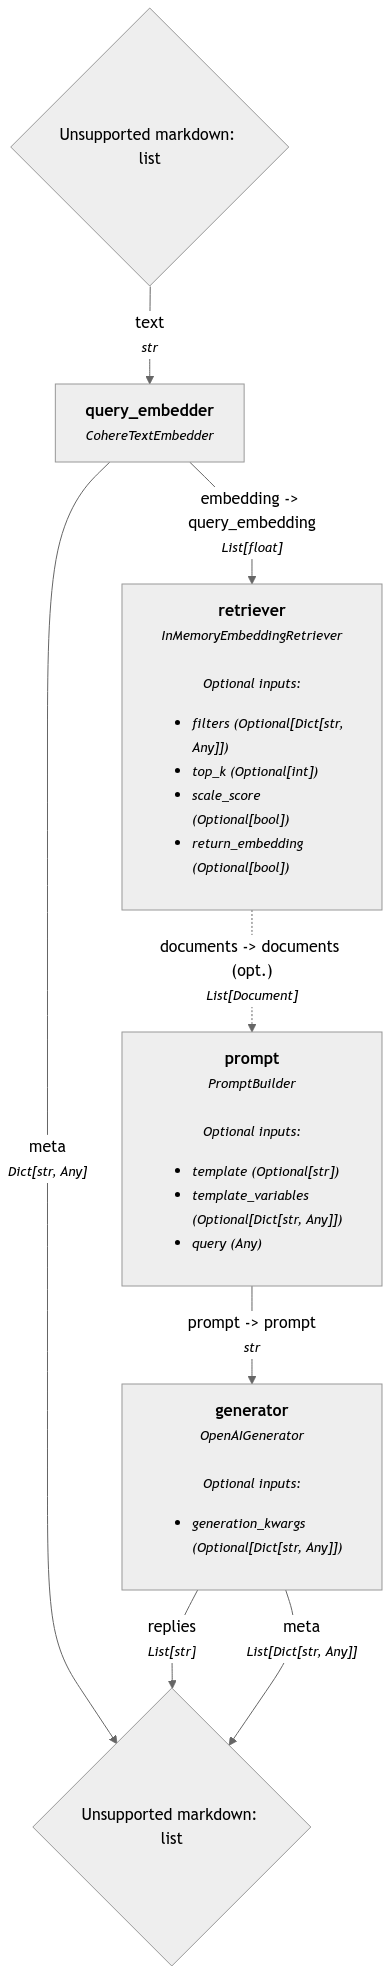

In [9]:
rag.show()

In [10]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question},
    }
)

print(result["generator"]["replies"][0])

To use Cohere with Haystack, you can follow these steps based on the provided context:

1. For Haystack 2.0:
   - Install the Cohere-Haystack package using pip.
   - Use Cohere models for embedding by initializing CohereTextEmbedder and CohereDocumentEmbedder components in your pipeline.
   - Use Cohere models for generative questions answering by initializing CohereTextEmbedder and CohereGenerator components in your pipeline.
   - Use Cohere models for ranking by initializing CohereRanker component in your pipeline.

2. For Haystack 1.x:
   - Install the Farm-Haystack package using pip.
   - Use Cohere models for embedding by initializing EmbeddingRetriever component in your pipeline.
   - Use Cohere models for generative questions answering by initializing PromptNode component in your pipeline.
   - Use Cohere models for reranking by initializing CohereRanker component in your pipeline.

Overall, you can leverage Cohere models for embedding, generative models (LLMs), and ranker model

### 3. Customize The Behaviour

In [11]:
prompt = """
You will be provided some context, followed by the URL that this context comes from.
Answer the question based on the context, and reference the URL from which your answer is generated.
Your answer should be in {{ language }}.
Context:
{% for doc in documents %}
   {{ doc.content }} 
   URL: {{ doc.meta['url']}}
{% endfor %}
Question: {{ query }}
Answer:
"""

In [12]:
query_embedder = CohereTextEmbedder(model="embed-english-v3.0", api_base_url=os.getenv("CO_API_URL"))
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
generator = OpenAIGenerator(model="gpt-3.5-turbo")

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

🚅 Components
  - query_embedder: CohereTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

In [13]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question, "language": "French"},
    }
)

print(result["generator"]["replies"][0])

Vous pouvez utiliser les modèles de Cohere dans vos pipelines Haystack en utilisant les générateurs, les incrusteurs et les classeurs de Cohere. Pour ce faire, vous devez installer cohere-haystack en exécutant la commande pip install cohere-haystack. Vous pouvez ensuite utiliser les modèles de Cohere pour l'incrustation de texte, la génération de texte et le classement de documents en fonction de leur pertinence sémantique par rapport à une requête spécifiée.

URL: https://haystack.deepset.ai/integrations/cohere
